#### Summary:
We've settled on final methods for both RNA and ATAC trait associations and I'm making final versions of notebooks for these. In this notebook I'll prepare the inputs for both modality associations, metadata inputs, etc. Then further notebooks will perform the associations and necessary meta-analyses.

In [1]:
suppressMessages(library(hdf5r)) 
suppressMessages(library(Seurat))
suppressMessages(library(DESeq2))

suppressMessages(library(dplyr)) 
suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 

suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(readr))

suppressMessages(library(enrichR))
suppressMessages(library(fgsea))
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

In [2]:
suppressMessages(library(ggplot2))
suppressMessages(library(tidyverse))

# Basic Inputs

In [3]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_rna <- c('HPAP-022','HPAP-026','HPAP-034','HPAP-035','HPAP-036',
                  'HPAP-037','HPAP-039','HPAP-040','HPAP-042','HPAP-044',
                  'HPAP-047','HPAP-052','HPAP-053','HPAP-054','HPAP-056',
                  'HPAP-059','HPAP-063','HPAP-074','HPAP-075','HPAP-077',
                  'HPAP-080','HPAP-082','HPAP-099','HPAP-101','HPAP-103',
                  'HPAP-104','HPAP-105')
length(hpap_samples_rna)

hpap_samples_atac <- c('HPAP-035','HPAP-036','HPAP-039','HPAP-040','HPAP-044',
                       'HPAP-045','HPAP-047','HPAP-049','HPAP-050','HPAP-052',
                       'HPAP-053','HPAP-054','HPAP-056','HPAP-059','HPAP-063',
                       'HPAP-067','HPAP-069','HPAP-072','HPAP-075','HPAP-077',
                       'HPAP-080','HPAP-092','HPAP-099','HPAP-101','HPAP-103',
                       'HPAP-104','HPAP-105')
length(hpap_samples_atac)

[1] 27

[1] 27

In [4]:
hpap_samples_all <- sort(unique(c(hpap_samples_rna,hpap_samples_atac)))
length(hpap_samples_all)

[1] 34

In [29]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations'

In [30]:
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')

# 1. Read in Seurat objects (Alberta and HPAP)

### Alberta

In [6]:
#read in the adata object 
rds_fp = '/nfs/lab/hmummey/multiomic_islet/intermediates/240308_28sample_combined.noDoublets.QCfilters.ATAC_peaks.FINAL_v2.w_union_peaks.rds'
adata1 = readRDS(rds_fp)
adata1

Loading required package: Signac



An object of class Seurat 
571775 features across 174819 samples within 4 assays 
Active assay: ATAC (210485 features, 210485 variable features)
 3 other assays present: RNA, SCT, ATAC_CTpeaks
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [7]:
#reclassify schwann cells as stellate (should do permanently at some point)
major_celltypes_fin <- adata1@meta.data$major_celltypes
major_celltypes_fin[major_celltypes_fin == "schwann"] <- "stellate"
adata1$major_celltypes_fin <- major_celltypes_fin

In [8]:
table(adata1$major_celltypes_fin)


     acinar       alpha        beta       delta      ductal endothelial 
      27387       44500       81100        8911        5452         342 
      gamma      immune    stellate 
       5504         633         990 

### HPAP RNA

In [42]:
#read in hpap object
rds_fp2 <- '/nfs/lab/relgamal/HPAP/HPAP_All/2023_01_27_hpap_res0p3.rds'
adata2 <- readRDS(rds_fp2)
adata2

An object of class Seurat 
36601 features across 192203 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [43]:
# subset down to the ND samples
adata2_nd <- subset(adata2, subset=Diabetes_Status_w_AAB=='ND')
adata2_nd

An object of class Seurat 
36601 features across 71871 samples within 1 assay 
Active assay: RNA (36601 features, 2000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [44]:
#rename celltypes to match the alberta ones -- combine mast and macrophage into immune
celltype_map <- unique(adata2_nd$cell_type)
new_celltypes <- c('alpha','alpha+beta','stellate','stellate','endothelial','delta',
                   'beta','gamma','immune', 'ductal','acinar','alpha','ductal','immune')
names(celltype_map) <- new_celltypes
#celltype_map

adata2_nd$matched_celltype <- plyr::mapvalues(adata2_nd$cell_type, from=celltype_map, to=names(celltype_map))
#table(adata2_nd$cell_type, adata2_nd$matched_celltype)

In [45]:
table(unique(adata2_nd$library) %in% hpap_samples_rna)


TRUE 
  27 

### HPAP ATAC

In [46]:
#read in hpap object
rds_fp3 <- '/nfs/lab/egriffin/HPAP/HPAP_atac_obj_withUnifiedpeaks_EG.rds'
adata3 <- readRDS(rds_fp3)
adata3

An object of class Seurat 
1303997 features across 97837 samples within 4 assays 
Active assay: ATAC_peaks (481311 features, 481311 variable features)
 3 other assays present: RNA, Final_Peaks, Unified_Peaks
 3 dimensional reductions calculated: lsi, harmony.atac, umap.atac

In [47]:
# subset down to the ND samples
adata3_nd <- subset(adata3, subset=condition=='Control')
adata3_nd

An object of class Seurat 
1303997 features across 66872 samples within 4 assays 
Active assay: ATAC_peaks (481311 features, 481311 variable features)
 3 other assays present: RNA, Final_Peaks, Unified_Peaks
 3 dimensional reductions calculated: lsi, harmony.atac, umap.atac

In [48]:
#rename celltypes to match the alberta ones -- combine mast and macrophage into immune
celltype_map <- unique(adata3_nd$Cell.Type)
new_celltypes <- c('acinar','ductal','alpha','beta','delta','immune','gamma',
                   'stellate','stellate','stellate','endothelial','ductal')
names(celltype_map) <- new_celltypes
#celltype_map

adata3_nd$matched_celltype <- plyr::mapvalues(adata3_nd$Cell.Type, from=celltype_map, to=names(celltype_map))
#table(adata3_nd$Cell.Type, adata3_nd$matched_celltype)

In [50]:
table(unique(adata3_nd$library) %in% hpap_samples_atac)


TRUE 
  27 

# 2. Metadata Preparation

## Alberta samples

### Read in phenotype metadata

In [97]:
#read in extended Alberta donor metadata
meta_dir <- '/nfs/lab/projects/multiomic_islet/data/sample_metadata'
fp <- file.path(meta_dir, '230801_donor_metadata_combined.tsv')
meta <- as.data.frame(fread(fp, sep='\t', header=TRUE))

#change colnames to be more R friendly
init_names <- colnames(meta)
colnames(meta) <- tolower(stri_replace_all_regex(gsub(r"{\s*\([^\)]+\)}","",colnames(meta)),
                                                 pattern=c(' ', '%', ',', ':','-','/'), 
                                                 replacement=c('_','pct','','','_','_div_'), vectorize=FALSE))
meta_names <- init_names
names(meta_names) <- colnames(meta)

#remove rows for samples we removed
meta2 <- meta[meta$record_id %in% alberta_samples,]

#remove unnecessary columns from meta
rm_cols <- c('rrid','known_medical_condition', 'was_the_tissue_purified?', 
             'excellent_pct','good_pct','fair_pct','poor_pct', 
             'ieq_per_cryopreservation_tube','number_of_cryopreserved_tubes_remaining',
             'ieq_per_cryopreservation_tube.1','number_of_snap_frozen_tubes_remaining',
             'is_an_embedded_biopsy_available_for_this_donor?', 'are_embedded_islets_available_for_this_donor?')
meta_cut <- meta2[,!colnames(meta2) %in% rm_cols]

meta1 <- meta_cut[,-1]
row.names(meta1) <- meta_cut$record_id
meta1$library <- row.names(meta1)

#shorten names for bmi and hba1c
colnames(meta1)[6] <- 'BMI'
colnames(meta1)[7] <- 'HbA1c'

#cut down to measurements of interest
meta1_cut <- select(meta1, age, sex, BMI, HbA1c, culture_time)
head(meta1_cut)

,age,sex,BMI,HbA1c,culture_time
,<int>,<chr>,<dbl>,<dbl>,<dbl>
R207,50,Female,22.2,NA,70
R217,71,Female,35.5,6.3,15
R218,73,Female,28.4,5.9,70
R221,44,Male,30.5,5.3,136
R223,54,Male,27.0,5.8,64
R226,30,Female,32.3,4.9,16


### Calculate additional sample level covariates for Alberta samples
- For both
    - Proportion of beta cells 
    - Total cells per donor
    - Number of cells per cell type
- RNA
    - Mean genes per cell type
- ATAC
    - Average TSSe

Some of these are repetitive, but I'm not exactly sure which I want to use, so I'll just calculate them all here.

In [98]:
#calculate proportion of beta cells
raw_cts <- as.data.frame(table(adata1@meta.data$major_celltypes_fin, adata1@meta.data$library)) %>%
            reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(raw_cts) <- raw_cts$Var1
raw_cts <- raw_cts[,-1]
prop_cts <- sweep(raw_cts, 2, colSums(raw_cts), `/`)
colnames(prop_cts) <- gsub('Freq.','',colnames(prop_cts))

#now convert this to a long format
long_prop_cts <- tibble::rownames_to_column(prop_cts, var='ct') %>% tidyr::pivot_longer(-ct, names_to='library', values_to='prop')
long_prop_cts$pc <- 100 * long_prop_cts$prop

#arrange into a dataframe with other info
beta_prop <- unlist(prop_cts['beta',])
num_cells <- as.vector(table(adata1$library))
prop_data1 <- data.frame(beta_prop_rna=beta_prop, beta_prop_atac=beta_prop, num_cells_rna=num_cells, num_cells_atac=num_cells)
head(prop_data1)

,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac
,<dbl>,<dbl>,<int>,<int>
R207,0.5168054,0.5168054,6248,6248
R217,0.2546716,0.2546716,5619,5619
R218,0.6887661,0.6887661,2172,2172
R221,0.2156263,0.2156263,4902,4902
R223,0.5443796,0.5443796,6343,6343
R226,0.5523939,0.5523939,5869,5869


In [99]:
#add in # cells per cell type info to metadata
#wrote a whole method to do this for HPAP but I think I can just use table LOL
results <- as.data.frame(table(adata1$library, adata1$major_celltypes_fin)) %>%
                reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(results) <- results$Var1
results <- results %>% select(-Var1)
colnames(results) <- paste0(gsub('Freq.','',colnames(results)),'_cells')
col_order <- paste0(joint_celltypes, '_cells')
results <- results %>% select(all_of(col_order))
head(results)

results1 <- copy(results)
colnames(results1) <- paste0(colnames(results1),'_rna')

results2 <- copy(results)
colnames(results2) <- paste0(colnames(results2),'_atac')

,beta_cells,alpha_cells,delta_cells,gamma_cells,acinar_cells,ductal_cells,endothelial_cells,immune_cells,stellate_cells
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R207,3229,2025,217,99,580,45,8,33,12
R217,1431,348,150,569,2489,614,2,10,6
R218,1496,227,133,83,165,52,2,4,10
R221,1057,905,183,44,2389,294,8,5,17
R223,3453,1616,225,101,711,203,7,8,19
R226,3242,1492,193,79,815,34,2,4,8


In [100]:
### Function to calculate mean_genes per sample for a cell type in an adata object
### Basically just average of nFeature_RNA for a celltype and sample pair
calc_mean_genes <- function(adata, celltypes, samples, celltype_col){
    # Collect mean of nFeature_RNA across samples and cell types
    mean_genes <- list()
    for (celltype in celltypes){
        gene_number <- c()
        for (sample in samples){
            cut_df <- adata@meta.data[adata@meta.data[,celltype_col] == celltype & adata@meta.data$library == sample,]
            gene_number <- c(gene_number, mean(cut_df$nFeature_RNA))
        }
        mean_genes[[celltype]] <- gene_number
    }

    # Format results as a df
    mean_genes_df <- as.data.frame(do.call(cbind, mean_genes))
    row.names(mean_genes_df) <- samples
    colnames(mean_genes_df) <- paste0(celltypes, '_mean_genes')
    return(mean_genes_df)
}

In [101]:
#calculate mean genes for alberta samples
alberta_mean_genes <- calc_mean_genes(adata1, joint_celltypes, alberta_samples, 'major_celltypes_fin')
head(alberta_mean_genes)

,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,2461.714,2194.071,2378.373,2086.808,1462.876,1842.333,1304.000,1118.606,1314.583
R217,2545.581,2296.241,2301.960,2353.497,1800.699,1868.313,1578.500,1458.000,1771.000
R218,1960.642,1809.938,1901.744,1472.627,1199.855,1384.827,1503.500,910.250,1505.200
R221,1951.037,1973.824,2066.421,1581.727,1315.754,1625.554,1376.625,1460.600,1243.706
R223,2690.103,2312.497,2464.196,2330.564,1562.639,1854.044,1592.143,1568.125,1826.053
R226,2923.349,2535.351,2881.332,2677.658,1516.972,2238.235,1328.000,2198.750,1739.250


In [102]:
### Function to calculate the average of a metadata col per sample (all cell types!)
calc_sample_mean <- function(adata, samples, feature_col){
    # Collect mean of relevant column across samples and cell types
    means <- c()
    for(sample in samples){
        cut_df <- adata@meta.data[adata@meta.data$library == sample,]
        means <- c(means, mean(cut_df[,feature_col]))
    }
   
    #Return the vector
    names(means) <- samples
    return(means)
}

In [103]:
#calculate sample level means for TSSe
tsse1 <- calc_sample_mean(adata1, alberta_samples, 'TSS.enrichment')
head(tsse1)

R207     R217     R218     R221     R223     R226 
3.450389 3.530508 3.641667 3.792649 2.992320 3.864731

In [104]:
#combine info into one df
meta1_cut$dataset <- 'Alberta'
meta1_fin <- cbind(meta1_cut, prop_data1, results1, results2, alberta_mean_genes) %>% relocate(dataset, .after=HbA1c)
meta1_fin$tsse <- tsse1
head(meta1_fin)

#save out df!
out_fp1 <- file.path(outdir, 'Alberta_metadata_all.tsv')
write.table(meta1_fin, out_fp1, sep='\t', quote=FALSE)

,age,sex,BMI,HbA1c,dataset,culture_time,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac,⋯,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes,tsse
,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,Female,22.2,NA,Alberta,70,0.5168054,0.5168054,6248,6248,⋯,2461.714,2194.071,2378.373,2086.808,1462.876,1842.333,1304.000,1118.606,1314.583,3.450389
R217,71,Female,35.5,6.3,Alberta,15,0.2546716,0.2546716,5619,5619,⋯,2545.581,2296.241,2301.960,2353.497,1800.699,1868.313,1578.500,1458.000,1771.000,3.530508
R218,73,Female,28.4,5.9,Alberta,70,0.6887661,0.6887661,2172,2172,⋯,1960.642,1809.938,1901.744,1472.627,1199.855,1384.827,1503.500,910.250,1505.200,3.641667
R221,44,Male,30.5,5.3,Alberta,136,0.2156263,0.2156263,4902,4902,⋯,1951.037,1973.824,2066.421,1581.727,1315.754,1625.554,1376.625,1460.600,1243.706,3.792649
R223,54,Male,27.0,5.8,Alberta,64,0.5443796,0.5443796,6343,6343,⋯,2690.103,2312.497,2464.196,2330.564,1562.639,1854.044,1592.143,1568.125,1826.053,2.992320
R226,30,Female,32.3,4.9,Alberta,16,0.5523939,0.5523939,5869,5869,⋯,2923.349,2535.351,2881.332,2677.658,1516.972,2238.235,1328.000,2198.750,1739.250,3.864731


## HPAP samples

### Read in phenotype metadata

In [170]:
# Read in Ruth's HPAP metadata table
meta2 <- as.data.frame(fread('/nfs/lab/relgamal/HPAP/Donor_Summary_127.csv'))
dim(meta2)
#head(meta2)

# Cut down to comparable measurements and rename/reorder columns to match
row.names(meta2) <- meta2$donor_ID
meta2_cut <- meta2[hpap_samples_all,c('age_years','gender','bmi','hba1c')]
colnames(meta2_cut) <- c('age','sex','BMI','HbA1c')

# Add in dataset and culture time
meta2_cut$dataset <- 'HPAP'
# meta2_more <- as.data.frame(fread('/nfs/lab/projects/multiomic_islet/data/sample_metadata/HPAP_Donors_scRNA-seq_Basic.csv'))
# row.names(meta2_more) <- meta2_more$DonorID
# meta2_more[hpap_samples_all,] %>% select(CultureStartDate, CultureHarvestDate)
culture_time_days <- c(3,2,3,3,2,4,4,4,5,5,5,2,5,4,4,2,6,2,5,3,NA,NA,3,4,2,5,2,NA,2,NA,4,6,6,2) #manually collect culture time (ex: 12/7/17-12/4/17 = 3days)
meta2_cut$culture_time <- 24 * culture_time_days
meta2_cut <- meta2_cut %>% rownames_to_column(var='library')

dim(meta2_cut)
head(meta2_cut)

[1] 127  83

[1] 34  7

,library,age,sex,BMI,HbA1c,dataset,culture_time
,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,HPAP-022,39,Female,34.70,4.7,HPAP,72
2,HPAP-026,24,Male,20.80,4.9,HPAP,48
3,HPAP-034,13,Male,18.60,5.2,HPAP,72
4,HPAP-035,35,Male,26.91,5.2,HPAP,72
5,HPAP-036,23,Female,16.00,5.2,HPAP,48
6,HPAP-037,35,Female,21.90,5.3,HPAP,96


In [171]:
#calculate proportion of beta cells -- RNA
raw_cts <- as.data.frame(table(adata2_nd@meta.data$matched_celltype, adata2_nd@meta.data$library)) %>%
            reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(raw_cts) <- raw_cts$Var1
raw_cts <- raw_cts[,-1]
prop_cts <- sweep(raw_cts, 2, colSums(raw_cts), `/`)
colnames(prop_cts) <- gsub('Freq.','',colnames(prop_cts))

#now convert this to a long format
long_prop_cts <- tibble::rownames_to_column(prop_cts, var='ct') %>% tidyr::pivot_longer(-ct, names_to='library', values_to='prop')
long_prop_cts$pc <- 100 * long_prop_cts$prop

#arrange into a dataframe with other info
beta_prop <- unlist(prop_cts['beta',])
num_cells <- as.vector(table(adata2_nd$library))
prop_data1 <- data.frame(beta_prop_rna=beta_prop, num_cells_rna=num_cells)
#head(prop_data1)

In [172]:
#calculate proportion of beta cells -- ATAC
raw_cts <- as.data.frame(table(adata3_nd@meta.data$matched_celltype, adata3_nd@meta.data$library)) %>%
            reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(raw_cts) <- raw_cts$Var1
raw_cts <- raw_cts[,-1]
prop_cts <- sweep(raw_cts, 2, colSums(raw_cts), `/`)
colnames(prop_cts) <- gsub('Freq.','',colnames(prop_cts))

#now convert this to a long format
long_prop_cts <- tibble::rownames_to_column(prop_cts, var='ct') %>% tidyr::pivot_longer(-ct, names_to='library', values_to='prop')
long_prop_cts$pc <- 100 * long_prop_cts$prop

#arrange into a dataframe with other info
beta_prop <- unlist(prop_cts['beta',])
num_cells <- as.vector(table(adata3_nd$library))
prop_data2 <- data.frame(beta_prop_atac=beta_prop, num_cells_atac=num_cells)
#head(prop_data2)

In [173]:
#combine prop_data into one df
prop_data1 <- prop_data1 %>% rownames_to_column(var='library')
prop_data2 <- prop_data2 %>% rownames_to_column(var='library')

prop_data <- full_join(prop_data1, prop_data2, by='library')
prop_data <- prop_data[,c(1,2,4,3,5)]
dim(prop_data)
head(prop_data)

[1] 34  5

,library,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac
,<chr>,<dbl>,<dbl>,<int>,<int>
1,HPAP-022,0.17037251,NA,3463,NA
2,HPAP-026,0.22222222,NA,414,NA
3,HPAP-034,0.08055556,NA,360,NA
4,HPAP-035,0.22299465,0.2517033,1870,2642
5,HPAP-036,0.18008107,0.2229767,1727,5449
6,HPAP-037,0.11766504,NA,3272,NA


In [174]:
#add in # cells per cell type info to metadata -- RNA
results1 <- as.data.frame(table(adata2_nd$library, adata2_nd$matched_celltype)) %>%
                reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(results1) <- results1$Var1
results1 <- results1 %>% select(-Var1)
colnames(results1) <- paste0(gsub('Freq.','',colnames(results1)),'_cells_rna')
col_order <- paste0(joint_celltypes, '_cells_rna')
results1 <- results1 %>% select(all_of(col_order))
#head(results1)

In [175]:
#add in # cells per cell type info to metadata -- ATAC
results2 <- as.data.frame(table(adata3_nd$library, adata3_nd$matched_celltype)) %>%
                reshape(idvar='Var1', timevar='Var2', direction='wide')
row.names(results2) <- results2$Var1
results2 <- results2 %>% select(-Var1)
colnames(results2) <- paste0(gsub('Freq.','',colnames(results2)),'_cells_atac')
col_order <- paste0(joint_celltypes, '_cells_atac')
results2 <- results2 %>% select(all_of(col_order))
#head(results2)

In [176]:
#combine num_cells into one df
results1 <- results1 %>% rownames_to_column(var='library')
results2 <- results2 %>% rownames_to_column(var='library')

results <- full_join(results1, results2, by='library')
dim(results)
head(results)

[1] 34 19

,library,beta_cells_rna,alpha_cells_rna,delta_cells_rna,gamma_cells_rna,acinar_cells_rna,ductal_cells_rna,endothelial_cells_rna,immune_cells_rna,stellate_cells_rna,beta_cells_atac,alpha_cells_atac,delta_cells_atac,gamma_cells_atac,acinar_cells_atac,ductal_cells_atac,endothelial_cells_atac,immune_cells_atac,stellate_cells_atac
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,HPAP-022,590,1699,133,48,53,75,127,73,334,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,HPAP-026,92,87,12,11,152,35,8,2,8,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,HPAP-034,29,52,4,2,171,74,3,3,13,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,HPAP-035,417,664,35,15,354,174,66,19,78,665,878,140,30,556,316,21,9,27
5,HPAP-036,311,524,34,28,595,126,25,21,29,1215,1930,671,89,942,492,25,37,48
6,HPAP-037,385,424,20,2,1953,304,35,26,102,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [177]:
hpap_mean_genes <- calc_mean_genes(adata2_nd, joint_celltypes, hpap_samples_all, 'matched_celltype')
hpap_mean_genes[is.na(hpap_mean_genes)] <- NA
hpap_mean_genes <- hpap_mean_genes %>% rownames_to_column(var='library') 
head(hpap_mean_genes)

,library,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,HPAP-022,3669.414,3373.147,2571.677,4404.521,1817.113,3678.880,2117.402,1812.945,3147.311
2,HPAP-026,3420.293,2101.138,1611.750,2526.909,1073.039,2694.914,1186.625,1298.500,1753.125
3,HPAP-034,4498.172,2616.404,1379.000,1951.000,2150.789,3323.135,1436.000,1102.333,2342.769
4,HPAP-035,3138.559,2171.274,1805.971,2827.067,1659.472,2779.764,1366.455,1295.737,1923.038
5,HPAP-036,3753.090,1953.011,1999.382,2925.250,1838.161,2880.111,1977.480,1480.143,2347.103
6,HPAP-037,3441.042,1910.719,1755.500,2269.000,1616.355,2726.039,1626.714,1346.077,1856.314


In [181]:
#calculate sample level means for TSSe
tsse2 <- calc_sample_mean(adata3_nd, hpap_samples_atac, 'TSS.enrichment')
tsse2_df <- data.frame(library=names(tsse2), tsse=tsse2)
head(tsse2_df)

,library,tsse
,<chr>,<dbl>
HPAP-035,HPAP-035,4.301869
HPAP-036,HPAP-036,4.297375
HPAP-039,HPAP-039,4.375953
HPAP-040,HPAP-040,4.340516
HPAP-044,HPAP-044,4.375415
HPAP-045,HPAP-045,4.398390


In [184]:
#combine info into one df
meta2_fin <- full_join(meta2_cut, prop_data, by='library') %>% 
                full_join(results, by='library') %>% 
                full_join(hpap_mean_genes, by='library') %>%
                full_join(tsse2_df, by='library')
row.names(meta2_fin) <- meta2_fin$library
meta2_fin <- meta2_fin %>% select(-library)
head(meta2_fin)

#save out df!
out_fp2 <- file.path(outdir, 'HPAP_metadata_all.tsv')
write.table(meta2_fin, out_fp2, sep='\t', quote=FALSE)

,age,sex,BMI,HbA1c,dataset,culture_time,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac,⋯,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes,tsse
,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HPAP-022,39,Female,34.70,4.7,HPAP,72,0.17037251,NA,3463,NA,⋯,3669.414,3373.147,2571.677,4404.521,1817.113,3678.880,2117.402,1812.945,3147.311,NA
HPAP-026,24,Male,20.80,4.9,HPAP,48,0.22222222,NA,414,NA,⋯,3420.293,2101.138,1611.750,2526.909,1073.039,2694.914,1186.625,1298.500,1753.125,NA
HPAP-034,13,Male,18.60,5.2,HPAP,72,0.08055556,NA,360,NA,⋯,4498.172,2616.404,1379.000,1951.000,2150.789,3323.135,1436.000,1102.333,2342.769,NA
HPAP-035,35,Male,26.91,5.2,HPAP,72,0.22299465,0.2517033,1870,2642,⋯,3138.559,2171.274,1805.971,2827.067,1659.472,2779.764,1366.455,1295.737,1923.038,4.301869
HPAP-036,23,Female,16.00,5.2,HPAP,48,0.18008107,0.2229767,1727,5449,⋯,3753.090,1953.011,1999.382,2925.250,1838.161,2880.111,1977.480,1480.143,2347.103,4.297375
HPAP-037,35,Female,21.90,5.3,HPAP,96,0.11766504,NA,3272,NA,⋯,3441.042,1910.719,1755.500,2269.000,1616.355,2726.039,1626.714,1346.077,1856.314,NA


## Combine metadata from both datasets into one table

In [31]:
#read back in both dfs
out_fp1 <- file.path(outdir, 'Alberta_metadata_all.tsv')
meta1 <- read.table(out_fp1, sep='\t', header=1)
head(meta1)

out_fp2 <- file.path(outdir, 'HPAP_metadata_all.tsv')
meta2 <- read.table(out_fp2, sep='\t', header=1)
head(meta2)

,age,sex,BMI,HbA1c,dataset,culture_time,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac,⋯,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes,tsse
,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,Female,22.2,NA,Alberta,70,0.5168054,0.5168054,6248,6248,⋯,2461.714,2194.071,2378.373,2086.808,1462.876,1842.333,1304.000,1118.606,1314.583,3.450389
R217,71,Female,35.5,6.3,Alberta,15,0.2546716,0.2546716,5619,5619,⋯,2545.581,2296.241,2301.960,2353.497,1800.699,1868.313,1578.500,1458.000,1771.000,3.530508
R218,73,Female,28.4,5.9,Alberta,70,0.6887661,0.6887661,2172,2172,⋯,1960.642,1809.938,1901.744,1472.627,1199.855,1384.827,1503.500,910.250,1505.200,3.641667
R221,44,Male,30.5,5.3,Alberta,136,0.2156263,0.2156263,4902,4902,⋯,1951.037,1973.824,2066.421,1581.727,1315.754,1625.554,1376.625,1460.600,1243.706,3.792649
R223,54,Male,27.0,5.8,Alberta,64,0.5443796,0.5443796,6343,6343,⋯,2690.103,2312.497,2464.196,2330.564,1562.639,1854.044,1592.143,1568.125,1826.053,2.992320
R226,30,Female,32.3,4.9,Alberta,16,0.5523939,0.5523939,5869,5869,⋯,2923.349,2535.351,2881.332,2677.658,1516.972,2238.235,1328.000,2198.750,1739.250,3.864731


,age,sex,BMI,HbA1c,dataset,culture_time,beta_prop_rna,beta_prop_atac,num_cells_rna,num_cells_atac,⋯,beta_mean_genes,alpha_mean_genes,delta_mean_genes,gamma_mean_genes,acinar_mean_genes,ductal_mean_genes,endothelial_mean_genes,immune_mean_genes,stellate_mean_genes,tsse
,<int>,<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HPAP-022,39,Female,34.70,4.7,HPAP,72,0.17037251,NA,3463,NA,⋯,3669.414,3373.147,2571.677,4404.521,1817.113,3678.880,2117.402,1812.945,3147.311,NA
HPAP-026,24,Male,20.80,4.9,HPAP,48,0.22222222,NA,414,NA,⋯,3420.293,2101.138,1611.750,2526.909,1073.039,2694.914,1186.625,1298.500,1753.125,NA
HPAP-034,13,Male,18.60,5.2,HPAP,72,0.08055556,NA,360,NA,⋯,4498.172,2616.404,1379.000,1951.000,2150.789,3323.135,1436.000,1102.333,2342.769,NA
HPAP-035,35,Male,26.91,5.2,HPAP,72,0.22299465,0.2517033,1870,2642,⋯,3138.559,2171.274,1805.971,2827.067,1659.472,2779.764,1366.455,1295.737,1923.038,4.301869
HPAP-036,23,Female,16.00,5.2,HPAP,48,0.18008107,0.2229767,1727,5449,⋯,3753.090,1953.011,1999.382,2925.250,1838.161,2880.111,1977.480,1480.143,2347.103,4.297375
HPAP-037,35,Female,21.90,5.3,HPAP,96,0.11766504,NA,3272,NA,⋯,3441.042,1910.719,1755.500,2269.000,1616.355,2726.039,1626.714,1346.077,1856.314,NA


In [32]:
#check that colnames all match and then merge
#colnames(meta1)
table(colnames(meta1) == colnames(meta2))

#combine dfs and write out final file
meta <- rbind(meta1, meta2)
dim(meta)


TRUE 
  38 

[1] 62 38

In [33]:
#scale all continuous variables 1,3,4,6-10, 29-38
cont_vars <- colnames(meta)[c(1,3,4,seq(6,10,1),seq(29,38,1))]
cont_vars

for (col_name in cont_vars){
    new_name <- paste0('scaled_', col_name)
    meta[new_name] <- as.double(scale(meta[,col_name]))
    meta <- meta %>% relocate(all_of(new_name), .after=all_of(col_name))
}
head(meta)

[1] "age"                    "BMI"                    "HbA1c"                 
 [4] "culture_time"           "beta_prop_rna"          "beta_prop_atac"        
 [7] "num_cells_rna"          "num_cells_atac"         "beta_mean_genes"       
[10] "alpha_mean_genes"       "delta_mean_genes"       "gamma_mean_genes"      
[13] "acinar_mean_genes"      "ductal_mean_genes"      "endothelial_mean_genes"
[16] "immune_mean_genes"      "stellate_mean_genes"    "tsse"

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,0.4825992,Female,22.2,-0.93547849,NA,NA,Alberta,70,0.07402343,⋯,1842.333,-0.7227589,1304.000,-0.69291246,1118.606,-0.869054467,1314.583,-0.9386930,3.450389,-1.2548308
R217,71,1.5811029,Female,35.5,1.15230857,6.3,1.6527657,Alberta,15,-1.34420328,⋯,1868.313,-0.6980603,1578.500,-0.11854077,1458.000,0.009333767,1771.000,-0.3702339,3.530508,-1.1219687
R218,73,1.6857223,Female,28.4,0.03777563,5.9,0.8536262,Alberta,70,0.07402343,⋯,1384.827,-1.1577107,1503.500,-0.27547292,910.250,-1.408302494,1505.200,-0.7012832,3.641667,-0.9376335
R221,44,0.1687410,Male,30.5,0.36742622,5.3,-0.3450829,Alberta,136,1.77589549,⋯,1625.554,-0.9288509,1376.625,-0.54094982,1460.600,0.016062849,1243.706,-1.0269696,3.792649,-0.6872598
R223,54,0.6918380,Male,27.0,-0.18199143,5.8,0.6538414,Alberta,64,-0.08069221,⋯,1854.044,-0.7116253,1592.143,-0.08999406,1568.125,0.294349182,1826.053,-0.3016668,2.992320,-2.0144478
R226,30,-0.5635948,Female,32.3,0.64998386,4.9,-1.1442224,Alberta,16,-1.31841734,⋯,2238.235,-0.3463746,1328.000,-0.64269417,2198.750,1.926474909,1739.250,-0.4097780,3.864731,-0.5677271


In [34]:
#saving out this combined metadata df in case
out_fp <- file.path(outdir, 'Alberta_HPAP_combined_metadata_all.tsv')
write.table(meta, out_fp, sep='\t', quote=FALSE)

## Plot distribution of metadata variables across datasets

In [197]:
subpop_colors = c('acinar'='#09850B', 'acinar_REG'='#CFE660',
                  'alpha_1'='#F51646', 'alpha_2'='#FA9EB2', 'alpha_3'='#B0072C', 
                  'beta_1'='#3F98E0', 'beta_2'='#134E7C','beta_3'='#CAE3F6', 
                  'beta_4'='#1D6DAF', 'beta_5'='#84BDEB','beta_6'='#1CCAD6',
                  'delta'='#E39E14', 
                  'ductal'='#F5DE6C', 
                  'endothelial'='#752BBA', #'endothelial'='#CF27A8',
                  'gamma_1'='#A1D99B', 'gamma_2'='#59BC4E',
                  'immune_gen'='#FED7EC', 'apc'='#F6138C', 'mast'='#F598C9', 
                  #'polyhormonal_1'='#752BBA', 'polyhormonal_2'='#AF7BE0', 
                  'schwann'='#A84E03', 'stellate_activated'='#DD6503', 'stellate_quiescent'='#FDBB84')

In [11]:
table(meta$sex, meta$dataset)

        
         Alberta HPAP
  Female       9   16
  Male        19   18

In [12]:
table(is.na(meta$HbA1c), meta$dataset)

       
        Alberta HPAP
  FALSE      23   32
  TRUE        5    2

In [13]:
table(is.na(meta$culture_time), meta$dataset)

       
        Alberta HPAP
  FALSE      28   30
  TRUE        0    4

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_

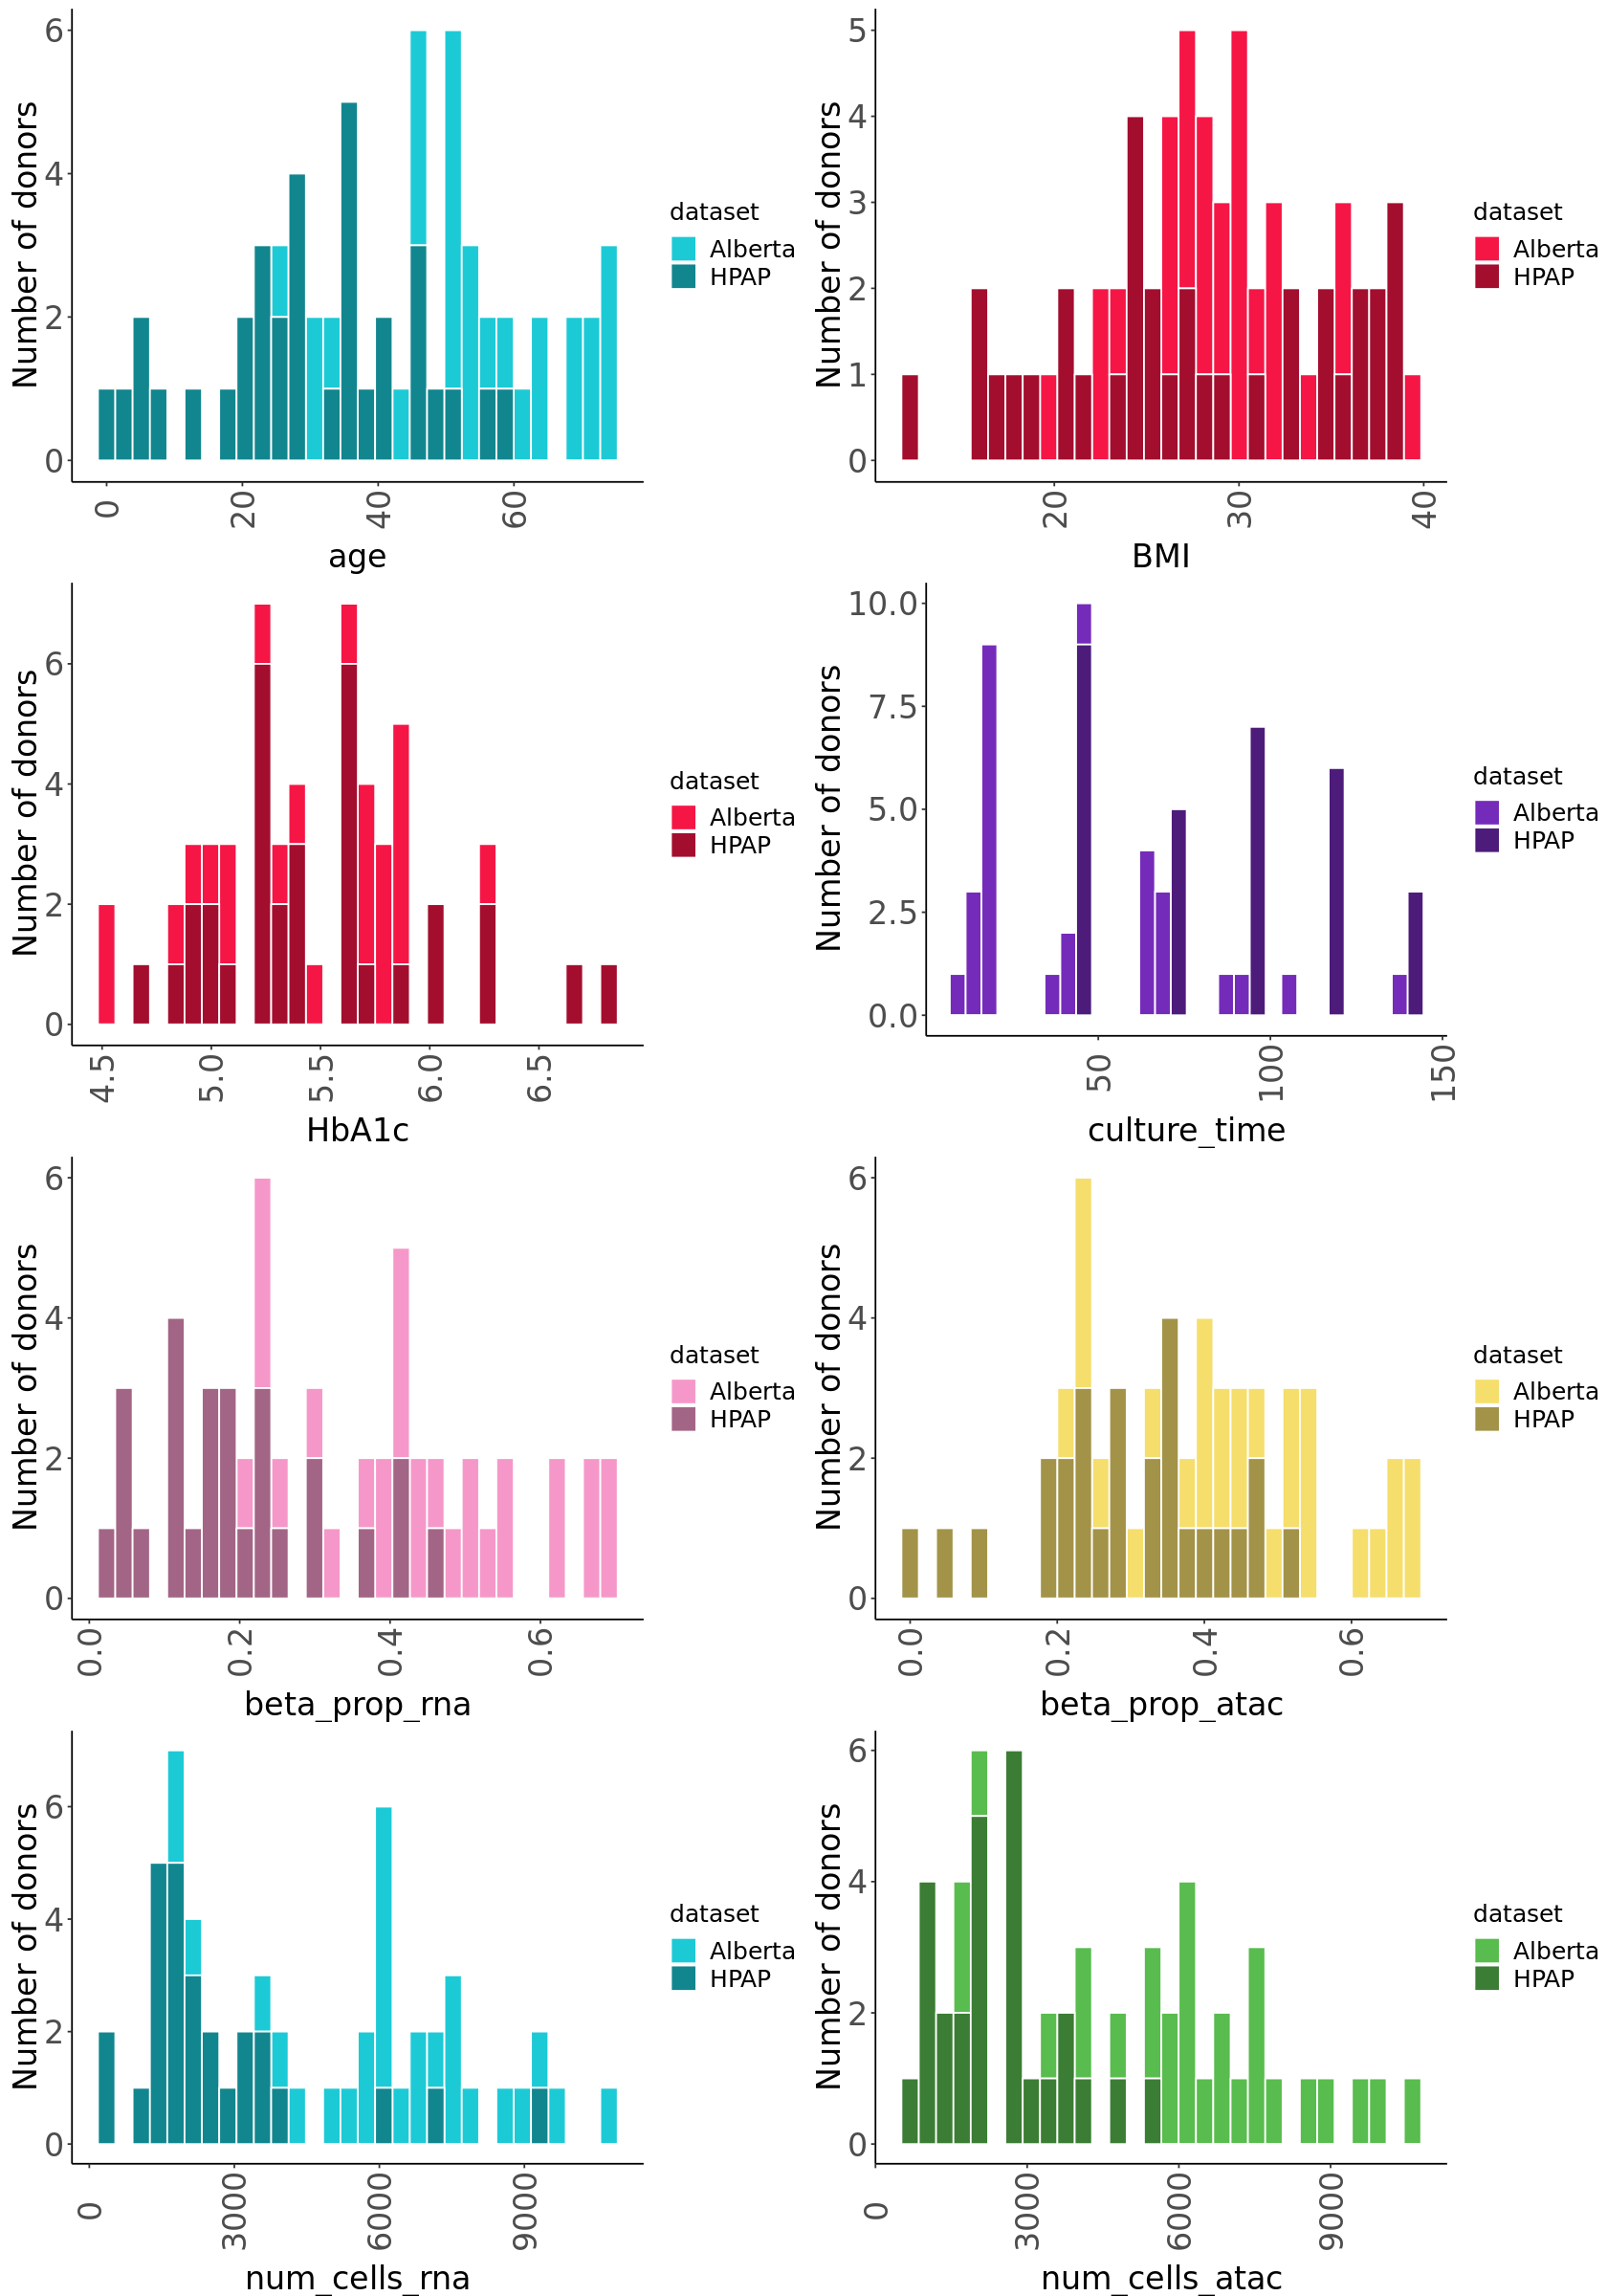

In [218]:
#for continuous variables
plot_list <- list()
for (meta_col in cont_vars[c(1,2,3,4,5,6,7,8)]){
    #basic prep
    options(repr.plot.width=7,repr.plot.height=5)
    theme_set(theme_classic())
    data <- data.frame(sample=row.names(meta), plot_col=meta[,meta_col], dataset=meta$dataset)
    
    #set up colors
    color1 <- sample(subpop_colors, 1)
    color2 <- colorRampPalette(colors = c('black',color1))(4)[3]
    colors <- c(color1, color2)
    names(colors) <- c('Alberta','HPAP')
    
    p1 <- ggplot(data, aes(x=plot_col, fill=dataset)) + 
        geom_histogram(position='stack', color='white') + 
        scale_fill_manual(values=colors) + 
        labs(x = meta_col, y="Number of donors") + 
        theme(axis.text.x=element_text(size=20, vjust=0.5, angle=90),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=20, vjust=-0.35),
            axis.title.y = element_text(size=20, vjust=0.5),
            legend.title = element_text(size=15),
            legend.text = element_text(size=15))        
    plot_list[[meta_col]] <- p1
}

options(repr.plot.width=14,repr.plot.height=20)
fig <- ggarrange(plotlist=plot_list, ncol=2, nrow=4)
fig

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 8 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite va

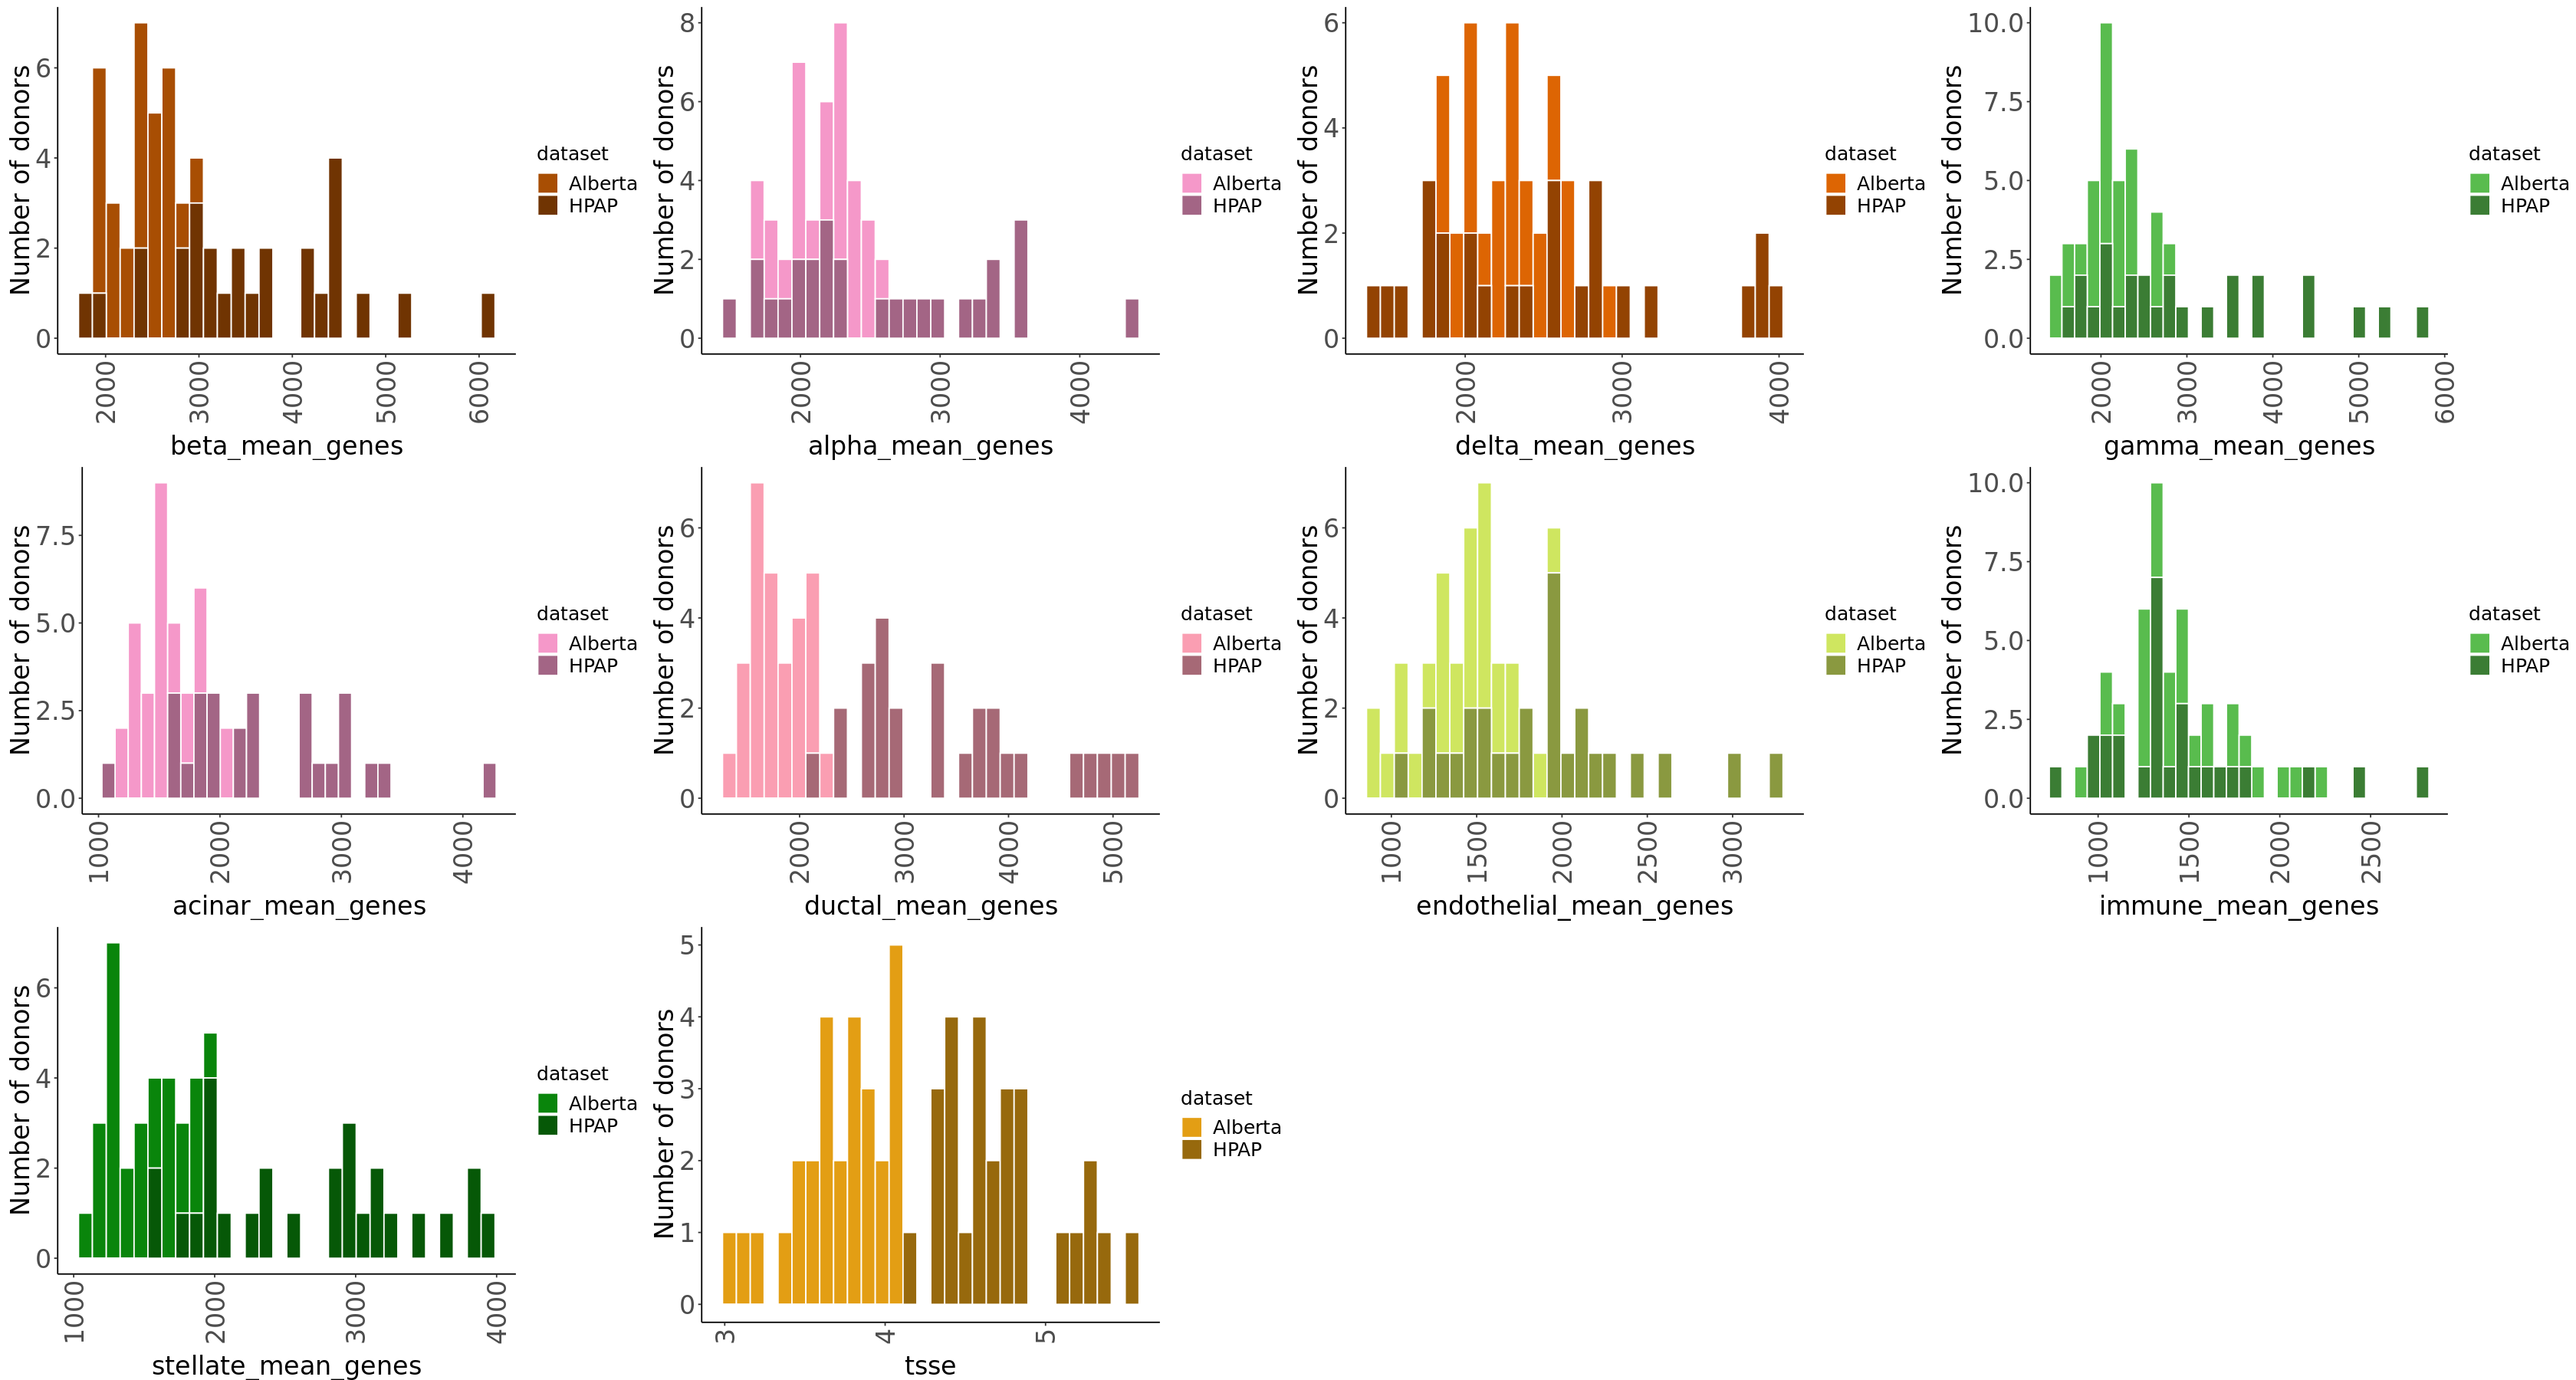

In [216]:
#for continuous variables
plot_list <- list()
for (meta_col in cont_vars[seq(9,18)]){
    #basic prep
    options(repr.plot.width=7,repr.plot.height=5)
    theme_set(theme_classic())
    data <- data.frame(sample=row.names(meta), plot_col=meta[,meta_col], dataset=meta$dataset)
    
    #set up colors
    color1 <- sample(subpop_colors, 1)
    color2 <- colorRampPalette(colors = c('black',color1))(4)[3]
    colors <- c(color1, color2)
    names(colors) <- c('Alberta','HPAP')
    
    p1 <- ggplot(data, aes(x=plot_col, fill=dataset)) + 
        geom_histogram(position='stack', color='white') + 
        scale_fill_manual(values=colors) + 
        labs(x = meta_col, y="Number of donors") + 
        theme(axis.text.x=element_text(size=20, vjust=0.5, angle=90),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=20, vjust=-0.35),
            axis.title.y = element_text(size=20, vjust=0.5),
            legend.title = element_text(size=15),
            legend.text = element_text(size=15))        
    plot_list[[meta_col]] <- p1
}

options(repr.plot.width=28,repr.plot.height=15)
fig <- ggarrange(plotlist=plot_list, ncol=4, nrow=3)
fig

### Look for any samples with outlier measures
Look for any outlier samples that maybe shouldn't be included in analyses (pretty sure there's one HPAP ATAC donor with very low BMI that was an outlier in most ATAC associations)

In [35]:
#read in metadata df
fp <- file.path(outdir, 'Alberta_HPAP_combined_metadata_all.tsv')
meta <- read.table(fp, sep='\t', header=1)
head(meta)

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R207,50,0.4825992,Female,22.2,-0.93547849,NA,NA,Alberta,70,0.07402343,⋯,1842.333,-0.7227589,1304.000,-0.69291246,1118.606,-0.869054467,1314.583,-0.9386930,3.450389,-1.2548308
R217,71,1.5811029,Female,35.5,1.15230857,6.3,1.6527657,Alberta,15,-1.34420328,⋯,1868.313,-0.6980603,1578.500,-0.11854077,1458.000,0.009333767,1771.000,-0.3702339,3.530508,-1.1219687
R218,73,1.6857223,Female,28.4,0.03777563,5.9,0.8536262,Alberta,70,0.07402343,⋯,1384.827,-1.1577107,1503.500,-0.27547292,910.250,-1.408302494,1505.200,-0.7012832,3.641667,-0.9376335
R221,44,0.1687410,Male,30.5,0.36742622,5.3,-0.3450829,Alberta,136,1.77589549,⋯,1625.554,-0.9288509,1376.625,-0.54094982,1460.600,0.016062849,1243.706,-1.0269696,3.792649,-0.6872598
R223,54,0.6918380,Male,27.0,-0.18199143,5.8,0.6538414,Alberta,64,-0.08069221,⋯,1854.044,-0.7116253,1592.143,-0.08999406,1568.125,0.294349182,1826.053,-0.3016668,2.992320,-2.0144478
R226,30,-0.5635948,Female,32.3,0.64998386,4.9,-1.1442224,Alberta,16,-1.31841734,⋯,2238.235,-0.3463746,1328.000,-0.64269417,2198.750,1.926474909,1739.250,-0.4097780,3.864731,-0.5677271


In [38]:
head(meta %>% arrange(BMI))

,age,scaled_age,sex,BMI,scaled_BMI,HbA1c,scaled_HbA1c,dataset,culture_time,scaled_culture_time,⋯,ductal_mean_genes,scaled_ductal_mean_genes,endothelial_mean_genes,scaled_endothelial_mean_genes,immune_mean_genes,scaled_immune_mean_genes,stellate_mean_genes,scaled_stellate_mean_genes,tsse,scaled_tsse
,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HPAP-044,3,-1.9759567,Female,12.00,-2.536638,5.3,-0.3450829,HPAP,120,1.3633204,⋯,3589.050,0.9378466,1926.100,0.6087875,2437.275,2.54380342,3881.088,2.2578448,4.375415,0.2791419
HPAP-036,23,-0.9297627,Female,16.00,-1.908733,5.2,-0.5448678,HPAP,48,-0.4932673,⋯,2880.111,0.2638574,1977.480,0.7162965,1480.143,0.06664188,2347.103,0.3472930,4.297375,0.1497275
HPAP-039,5,-1.8713373,Female,16.30,-1.861640,6.8,2.6516900,HPAP,96,0.7444579,⋯,2452.987,-0.1422097,1309.465,-0.6814771,1371.962,-0.21334120,2565.773,0.6196423,4.375953,0.2800346
HPAP-047,8,-1.7144082,Male,16.82,-1.780012,NA,NA,HPAP,48,-0.4932673,⋯,2353.710,-0.2365926,1053.528,-1.2170066,1511.750,0.14844458,1921.810,-0.1824028,4.430672,0.3707747
HPAP-042,1,-2.0805761,Male,17.90,-1.610477,5.6,0.2542716,HPAP,120,1.3633204,⋯,3285.076,0.6488574,1438.812,-0.4108278,755.400,-1.80907105,1604.934,-0.5770659,NA,NA
HPAP-034,13,-1.4528597,Male,18.60,-1.500594,5.2,-0.5448678,HPAP,72,0.1255953,⋯,3323.135,0.6850407,1436.000,-0.4167119,1102.333,-0.91117005,2342.769,0.3418948,NA,NA


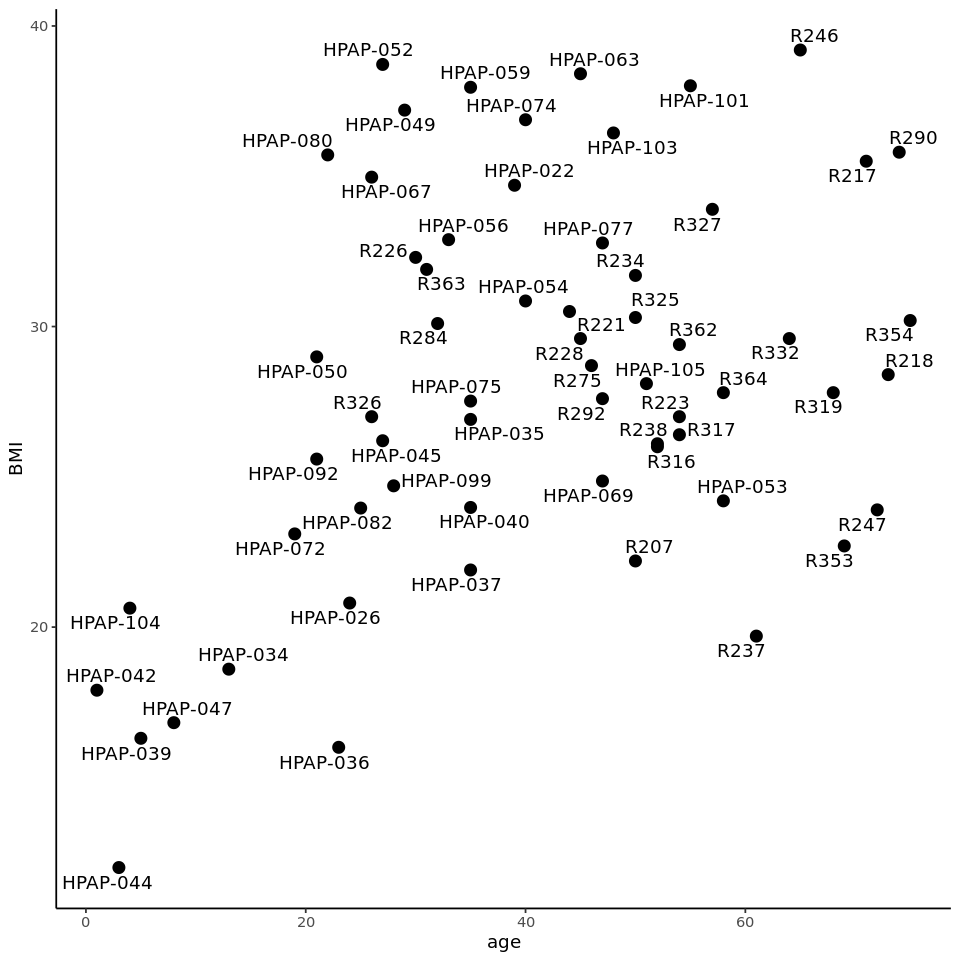

In [92]:
#are BMI and age related? somewhat but mainly just younger ages
options(repr.plot.height=8, repr.plot.width=8)
ggplot(meta, aes(x=age, y=BMI), label=library) + 
    geom_point(size=3) + 
    geom_text_repel(aes(label=library))

Warning message:
“Removed 14 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


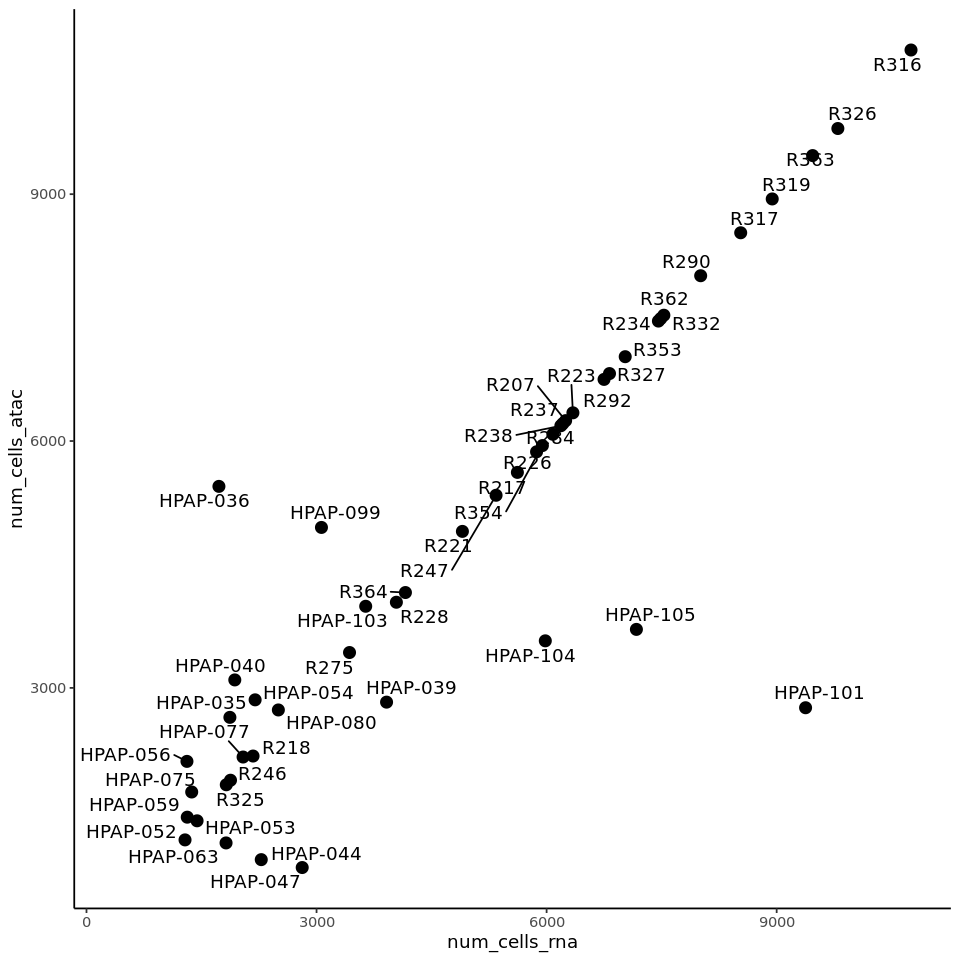

In [93]:
#are BMI and age related? somewhat but mainly just younger ages
options(repr.plot.height=8, repr.plot.width=8)
ggplot(meta, aes(x=num_cells_rna, y=num_cells_atac), label=library) + 
    geom_point(size=3) + 
    geom_text_repel(aes(label=library))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”


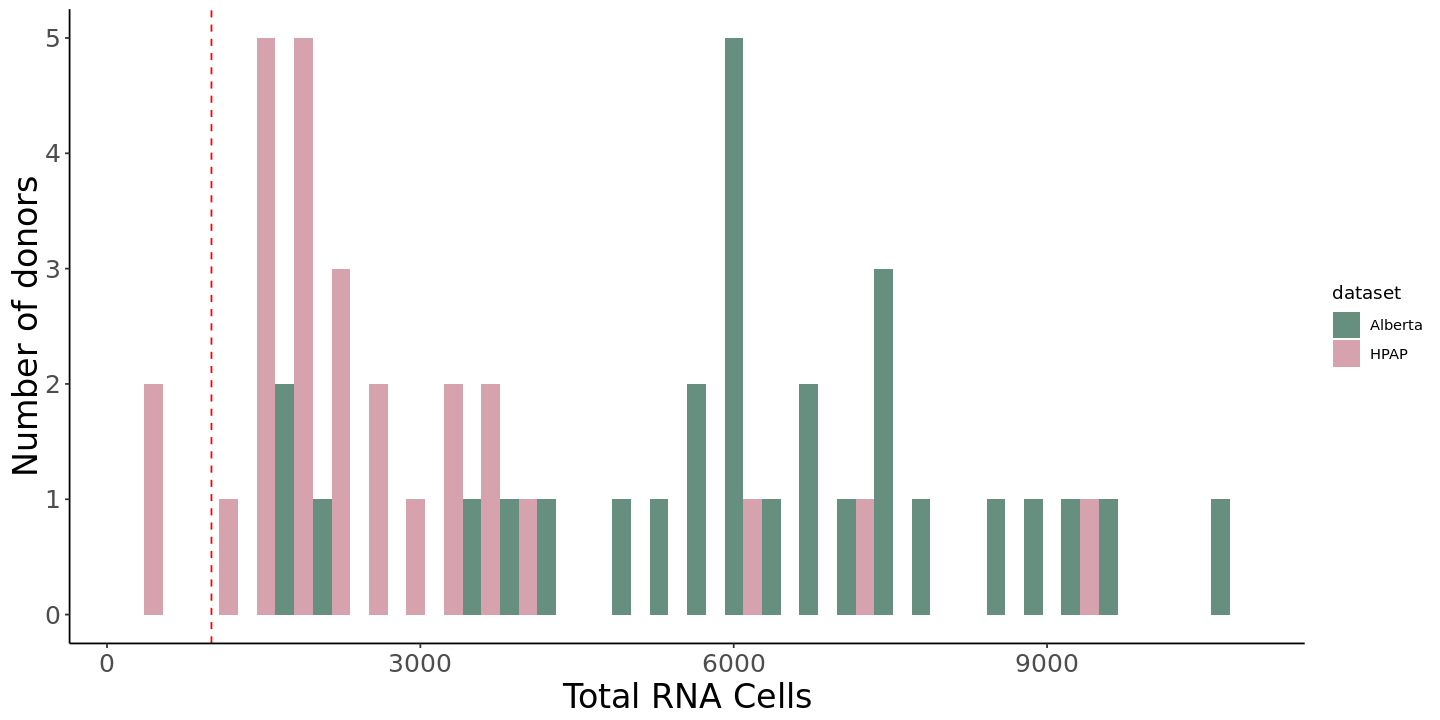

In [101]:
theme_set(theme_classic())
options(repr.plot.width=12, repr.plot.height=6)
p1 <- ggplot(meta, aes(x=num_cells_rna, fill=dataset)) + 
    geom_histogram(position='dodge') + geom_vline(xintercept=1000, color='red', linetype=2) + 
    scale_fill_manual(values=c('Alberta'='#668F80', 'HPAP'='#D6A2AD')) + 
    xlab('Total RNA Cells') + ylab('Number of donors') +
    theme(axis.title.x=element_text(size=20, vjust=0.5), 
          axis.text.x=element_text(size=15, vjust=0.5),
          axis.title.y=element_text(size=20, vjust=0.5),
          axis.text.y=element_text(size=15, vjust=0.5))
p1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7 rows containing non-finite values (`stat_bin()`).”


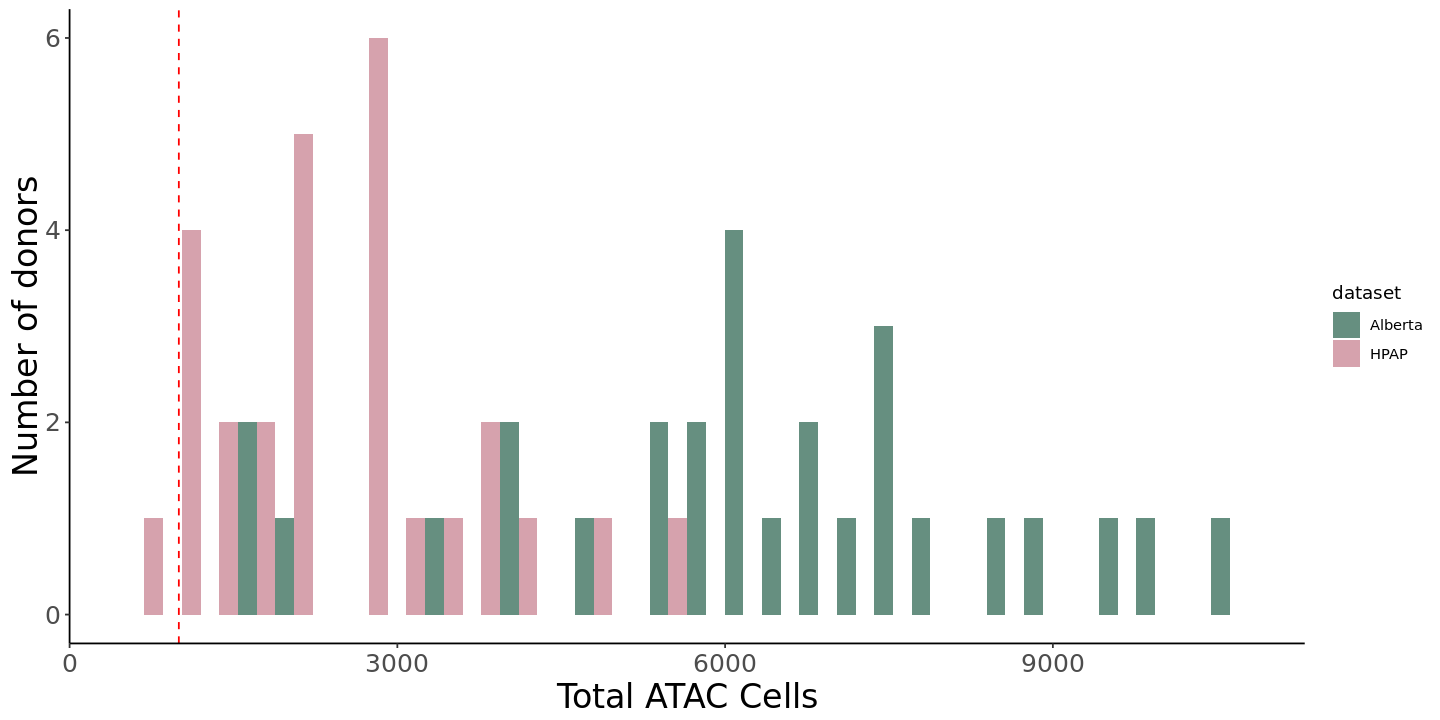

In [102]:
theme_set(theme_classic())
options(repr.plot.width=12, repr.plot.height=6)
p1 <- ggplot(meta, aes(x=num_cells_atac, fill=dataset)) + 
    geom_histogram(position='dodge') + geom_vline(xintercept=1000, color='red', linetype=2) + 
    scale_fill_manual(values=c('Alberta'='#668F80', 'HPAP'='#D6A2AD')) + 
    xlab('Total ATAC Cells') + ylab('Number of donors') +
    theme(axis.title.x=element_text(size=20, vjust=0.5), 
          axis.text.x=element_text(size=15, vjust=0.5),
          axis.title.y=element_text(size=20, vjust=0.5),
          axis.text.y=element_text(size=15, vjust=0.5))
p1

In [104]:
subset(meta, num_cells_rna < 1000 | num_cells_atac < 1000) %>% select(library, age, sex, BMI, HbA1c, num_cells_rna, num_cells_atac)

,library,age,sex,BMI,HbA1c,num_cells_rna,num_cells_atac
,<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
30,HPAP-026,24,Male,20.80,4.9,414,NA
31,HPAP-034,13,Male,18.60,5.2,360,NA
38,HPAP-044,3,Female,12.00,5.3,2813,817
40,HPAP-047,8,Male,16.82,NA,2279,913
52,HPAP-074,40,Female,36.88,6.3,991,NA


### DECISION: I think based off of this, it makes sense to only use samples with 1000 cells in that modality to begin with, regardless of the distribution of cells per cell type

# 3. Prepare combined pseudobulk counts tables for DESeq
I already have ALL of these matrices made from previous notebooks, so I'll just softlink all of the locations for that to my final output directory. Keeping track of original places here so I know not to delete these files: 
- RNA: `/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/231005_RNA_DESeq_v3_wHPAP_culturetime/merged_sample_matrices` ***NOTE: HPAP sample names have . instead of - here***
- ATAC: `/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240313_ATAC_DESeq_v3_wHPAP_culturetime/merged_sample_matrices` ***NOTE: HPAP sample names have - here***

In [24]:
#creating softlinks here
prev_dir_rna <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/231005_RNA_DESeq_v3_wHPAP_culturetime/merged_sample_matrices'
prev_dir_atac <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240313_ATAC_DESeq_v3_wHPAP_culturetime/merged_sample_matrices'

for(celltype in joint_celltypes){
    prev_fp_rna <- file.path(prev_dir_rna,sprintf('%s_sample_gex_total_counts.txt',celltype))
    new_fp_rna <- file.path(outdir,'RNA','merged_sample_matrices',sprintf('%s_sample_RNA_total_counts.txt',celltype))
    cmd1 <- sprintf('ln -s %s %s',prev_fp_rna,new_fp_rna)
    system(cmd1)
    
    prev_fp_atac <- file.path(prev_dir_atac, sprintf('%s_sample_union_peaks_total_counts.txt',celltype))
    new_fp_atac <- file.path(outdir,'ATAC','merged_sample_matrices', sprintf('%s_sample_ATAC_total_counts.txt',celltype))
    cmd2 <- sprintf('ln -s %s %s',prev_fp_atac, new_fp_atac)
    system(cmd2)
}

### For reference: the notebooks where I made these matrices:
- RNA genes: `/nfs/lab/hmummey/multiomic_islet/notebooks/trait_associations/231004_RNA_DESeq_Trait_Associations_v3_wHPAP_Prep.ipynb`
- ATAC union peaks: 
    - Alberta: `/nfs/lab/hmummey/multiomic_islet/notebooks/trait_associations/240313_ATAC_DESeq_Trait_Associations_v3_wHPAP_Prep.ipynb`
    - HPAP (featureCounts): `/nfs/lab/hmummey/multiomic_islet/notebooks/trait_associations/230920_Generate%20HPAP_ATAC_DESeq_matrices_featureCounts.ipynb`